## 5.1 Contents<a id='5.1_Contents'></a>
* [5 Modeling](#5_Modeling)
  * [5.1 Contents](#5.1_Contents)
  * [5.2 Introduction](#5.2_Introduction)
  * [5.3 Imports](#5.3_Imports)
  * [5.4 Cox model prediction](#5.4_Cox_model_prediction)
    * [5.4.1 Survival age hazard ratio prediction](#5.4.1_Survival_age_hazard_ratio_prediction)
    * [5.4.2 Visualize survival curve](#5.4.2_Visualize_survival_curve)
    * [5.4.3 Visualize survival probabilities of default](#5.4.3_Visualize_survival_probabilities_of_default)
    * [5.4.4 Visualize partial effects on outcome](#5.4.4_Visualize_partial_effects_on_outcome)

## 5.2 Introduction<a id='5.2_Introduction'></a>

The following models were implemented as part of the previous step on preprocessing and training data development:
1. Random Forest
2. Cox survival model

Based on the model performance metrics, the Cox survival model was determined to be a better model to proceed with. 
In this modeling step, a pipeline is setup to handle preprocessing the loan test data. The Cox model is used to run predictions on the test data.

## 5.3 Imports<a id='5.3_Imports'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing 
import lifelines
from lifelines import CoxPHFitter
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pickle as pk
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', None)

## 5.4 Cox model prediction<a id='5.4_Cox_model_prediction'></a>

Read in loan test data, state/bank default rates, and Cox model saved from previous step. Implement a sample model prediction pipeline for data preprocessing/encoding loan test data. Additional preprocessing steps such as updating defaults, populating missing values with appropriate values like mean, median, mode, etc would require these default values to be saved as part of the model training pipeline (the model training pipeline is not being implemented here). The loan test data we are using here already has these defaults populated as part of the prior step.

In [2]:
#read in loan test data features for Cox model prediction (survival age, hazard ratios)
df_loan=pd.read_csv('../data/processed/X_test.csv',index_col=0)

#read in state and bank default rates saved from training dataset as part of model training
default_rates_df=pd.read_csv('../data/state_bank_default_rates.csv',index_col=0).reset_index().drop(columns=['index'])
state_default_rate_df=default_rates_df[['Property_State','state_default_rate']]
state_default_rate_df.drop_duplicates(inplace=True)
bank_default_rate_df=default_rates_df[['Servicer_Name','bank_default_rate']]
bank_default_rate_df.drop_duplicates(inplace=True)
#load the saved cox model
model=pk.load(open('../models/cox_model.pkl','rb'))
#pipeline to encode categorical features
categorical_features=['First_Time_Homebuyer_Flag','Prepayment_Penalty_Mortgage_(PPM)_Flag','Property_Type','Loan_Purpose','HARP_Indicator']

categorical_features1=['Occupancy_Status','Channel']

transformer = ColumnTransformer(transformers=[('n', preprocessing.OneHotEncoder(), categorical_features1),('c', preprocessing.OrdinalEncoder(), categorical_features)])

preprocess_pipeline = Pipeline(steps=
                    [
                        ('preprocess', transformer),
                    ]
                   )

encoded_df=pd.DataFrame(preprocess_pipeline.fit_transform(df_loan),columns=['Occupancy_Status_I','Occupancy_Status_P','Occupancy_Status_S','Channel_B','Channel_C','Channel_R','Channel_T','First_Time_Homebuyer_Flag','Prepayment_Penalty_Mortgage_(PPM)_Flag','Property_Type','Loan_Purpose','HARP_Indicator'])
#drop unneeded columns as determined in EDA
drop_col_df=df_loan.drop(columns=['First_Payment_Date','Maturity_Date','Current_Loan_Delinquency_Status','Zero_Balance_Removal_UPB','Zero_Balance_Effective_Date','Monthly_Reporting_Period','Seller_Name','Metropolitan_Statistical_Area_(MSA)_Or_Metropolitan_Division','Postal_Code','Occupancy_Status','Channel'],errors='ignore').reset_index().drop(columns=['index'])
drop_col_df=drop_col_df[drop_col_df.columns.difference(encoded_df.columns)]
#Merge in the encoded columns
X_df=pd.concat([encoded_df,drop_col_df],axis=1)
#Merge in bank/state default rates
X_df=X_df.merge(bank_default_rate_df, how='left', on='Servicer_Name').drop(columns=['Servicer_Name'])
X_df=X_df.merge(state_default_rate_df, how='left',on='Property_State').drop(columns=['Property_State'])

C:\Users\rohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\rohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Reorder the feature columns based on the trained model coefficients. The original ordering of feature columns gets changed as part of feature encoding. The original order is helpful to compute hazard ratios later on. 

In [3]:
X_df = X_df.reindex(columns=np.array(model.summary['coef'].index))

Reviewing trained model coefficients.

In [5]:
model.summary['coef'].sort_values(ascending=False)

covariate
state_default_rate                        0.97
bank_default_rate                         0.34
Channel_B                                 0.14
Current_Interest_Rate                     0.13
Channel_C                                 0.10
Occupancy_Status_P                        0.05
Loan_Purpose                              0.05
Number_of_Borrowers                       0.04
Remaining_Months_to_Legal_Maturity        0.01
Mortgage_Insurance_Percentage_(MI_%)      0.00
Credit_Score                              0.00
Original_UPB                              0.00
Current_Actual_UPB                       -0.00
Interest_Bearing_UPB                     -0.00
Current_Deferred_UPB                     -0.00
Original_Loan-to-Value_(LTV)             -0.00
Original_Debt-to-Income_(DTI)_Ratio      -0.00
Original_Interest_Rate                   -0.00
Original_Combined_Loan-to-Value_(CLTV)   -0.00
Property_Type                            -0.01
Channel_R                                -0.01
Ori

### 5.4.1 Survival age hazard ratio prediction<a id='5.4.1_Survival_age_hazard_ratio_prediction'></a>

Running model predictions to compute/predict survival ages based on test data features.

In [6]:
y_pred=model.predict_expectation(X_df)

Running model predictions to compute/predict survival probabilities based on test data features.

In [ ]:
surv_df=model.predict_survival_function(X_df,np.arange(0,296,1)).T

Compute model predictions (hazard ratios) and visualizing survival curve.

In [8]:
features=X_df.values
coefficients=np.array(model.summary['coef'])
outcome=np.dot(features,coefficients)
outcome=np.array(outcome)
outcome_exp=np.exp(outcome)

In [9]:
m=model.baseline_hazard_
h=np.array(m['baseline hazard'])

In [10]:
from scipy import interpolate
probs=[]
for i in range(0,len(y_pred)):
    x=y_pred[i]
    q=interpolate.interp1d([int(np.floor(x)),int(np.ceil(x))],[h[int(np.floor(x))],h[int(np.ceil(x))]],kind='linear')
    probs.append(q(x)*outcome_exp[i])

### 5.4.2 Visualize survival curve<a id='5.4.2_Visualize_survival_curve'></a>

<AxesSubplot:title={'center':'Hazard ratios over time'}, xlabel='Survival age in months', ylabel='Hazard ratio'>

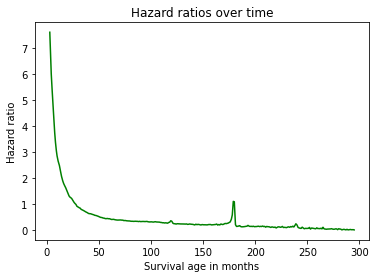

In [45]:
plt.title("Hazard ratios over time")
plt.ylabel("Hazard ratio")
plt.xlabel("Survival age in months")
sns.lineplot(x=y_pred,y=probs,color='green')

The survival curve graph above shows the risk (hazard ratio) as predicted by the model for the various survival ages (months). As shown, the risk is higher in the initial period of the loan.

In [13]:
#Read in loan test data target defaults/non-defaults
y_df=pd.read_csv('../data/processed/y_test.csv',index_col=0)

In [14]:
y_df.head()

,default_status,Loan_Age
372454,1,32
398158,2,72
984365,2,23
780854,2,89
438520,2,21


In [23]:
#Merging in test data features, target
test_pred_df=pd.concat([X_df,y_df.reset_index()],axis=1).drop(columns=['index'])

In [24]:
test_pred_df['default_status'].value_counts()

2    184199
0     57560
1      3241
Name: default_status, dtype: int64

In [25]:
#Merging in model survival age predictions
test_pred_df['survival']=y_pred

In [26]:
test_pred_df.head()

,Credit_Score,First_Time_Homebuyer_Flag,Mortgage_Insurance_Percentage_(MI_%),Number_of_Units,Original_Combined_Loan-to-Value_(CLTV),Original_Debt-to-Income_(DTI)_Ratio,Original_UPB,Original_Loan-to-Value_(LTV),Original_Interest_Rate,Prepayment_Penalty_Mortgage_(PPM)_Flag,Property_Type,Loan_Purpose,Original_Loan_Term,Number_of_Borrowers,HARP_Indicator,Current_Actual_UPB,Remaining_Months_to_Legal_Maturity,Current_Interest_Rate,Current_Deferred_UPB,Interest_Bearing_UPB,MSA,Occupancy_Status_I,Occupancy_Status_P,Occupancy_Status_S,Channel_B,Channel_C,Channel_R,Channel_T,bank_default_rate,state_default_rate,default_status,Loan_Age,survival
0,746,0.00,0.00,2,72.00,48.00,335000.00,72.00,6.62,0.00,4.00,0.00,360,1,0.00,0.00,328,6.62,0.00,0.00,1,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.69,1.58,1,32,32.37
1,704,0.00,0.00,1,70.00,25.00,270000.00,70.00,5.88,0.00,4.00,0.00,360,1,0.00,0.00,288,5.88,0.00,0.00,1,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.97,1.40,2,72,48.92
2,679,0.00,0.00,1,79.00,35.00,422000.00,79.00,5.50,0.00,4.00,1.00,360,1,0.00,0.00,337,5.50,0.00,0.00,1,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.55,1.46,2,23,36.72
3,714,0.00,0.00,1,96.00,45.00,187000.00,96.00,4.00,0.00,4.00,1.00,180,1,1.00,0.00,91,4.00,0.00,0.00,1,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.87,1.56,2,89,97.84
4,791,1.00,0.00,1,36.00,39.00,150000.00,36.00,6.38,0.00,0.00,2.00,360,2,0.00,0.00,339,6.38,0.00,0.00,0,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.69,1.58,2,21,26.51


In [35]:
#subset dataframe to just defaults
test_pred_defaults_df=test_pred_df[test_pred_df['default_status']==1]

In [36]:
len(test_pred_defaults_df['survival'])

3241

In [38]:
#Generating lists of loan age and survival probabilities for visualization
x_val=[]
y_val=[]
for i in range(0,3241):
    x_val.append(test_pred_defaults_df['Loan_Age'][test_pred_defaults_df.index[i]])
    y_val.append(surv_df[test_pred_defaults_df['Loan_Age'][test_pred_defaults_df.index[i]]][test_pred_defaults_df.index[i]])

### 5.4.3 Visualize survival probabilities of default<a id='5.4.3_Visualize_survival_probabilities_of_default'></a>

C:\Users\rohan\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Loan Age in months')

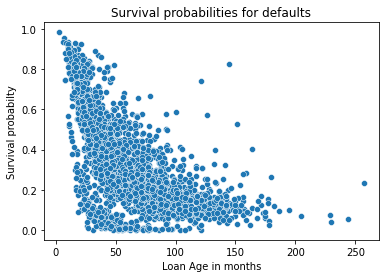

In [57]:
sns.scatterplot(x_val,y_val)
plt.title('Survival probabilities for defaults')
plt.ylabel("Survival probabilty")
plt.xlabel("Loan Age in months")

The graph above plots survival probabilities against loan age for defaults. As predicted by the model, cluster of defaults are in the region of lower survival probability.

In [47]:
#computing min, median, and max current interest rates in the test data. These values will be used to show the partial effects of current interest rate on the model outcome. 
print(test_pred_df['Current_Interest_Rate'].max(),test_pred_df['Current_Interest_Rate'].min(),np.median(test_pred_df['Current_Interest_Rate']))

10.625 2.0 6.25


### 5.4.4 Visualize partial effects on outcome<a id='5.4.4_Visualize_partial_effects_on_outcome'></a>

Text(0.5, 1.0, 'Partial effects of interest rate on model outcome')

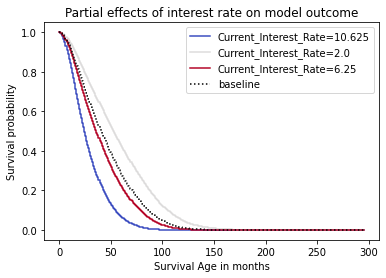

In [49]:
model.plot_partial_effects_on_outcome(covariates='Current_Interest_Rate', values=[10.625,2.0,6.25], cmap='coolwarm')
plt.xlabel("Survival Age in months")
plt.ylabel("Survival probability")
plt.title("Partial effects of interest rate on model outcome")

The partial effects on outcome graph plots the survival probabilities over time represented by the survival age (months). The model training generated a positive coefficient for the current interest rate feature. As expected, the above 'partial effects on outcome' graph shows that having a higher interest rate leads to a lower probability of survival.